# Transfer Learning


---

### Importing libraries

In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

#### Checking if CUDA capable GPU is available for training....  
(Training with GPU results in significantly lesser training time)

In [2]:
train_on_gpu = torch.cuda.is_available()  #returns True if CUDA enabled GPU is available

if train_on_gpu == True :
    print('CUDA is available!  Training on GPU ...')
    print('\n')
    print(torch.cuda.get_device_properties(0))
    device = 'cuda'
    
else:
    print('CUDA is not available.  Training on CPU ...')
    device = 'cpu'
    

CUDA is available!  Training on GPU ...


_CudaDeviceProperties(name='NVIDIA GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4096MB, multi_processor_count=6)


## Load and Transform our Data

Using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class, which makes it very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Where, in this case, the root folder for training is `dataset/train/` and the classes are the names of art types.

Likewise, `dataset/valid` and `dataset/test` for validation and testing respectively.

In [3]:
# define training data, validation data and test data directories
dataset_dir = 'dataset/'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
valid_dir = os.path.join(dataset_dir, 'test')


# classes are folders in each directory with these names
classes = os.listdir(train_dir)
print("Classes: ",classes)
print("Total no. of classes = ",len(classes))

Classes:  ['0', '1', '2', '3', '4']
Total no. of classes =  5


### Transforming the Data

While performing transfer learning, we shape our input data into the shape that the pre-trained model expects. Most of them  expect `224`-dim square images as input, so resizing each art image to fit this model.

### Data-Augmentation
Using data augmentation on training images.
1. Randomly rotating the training by 30 degress.
2. Randomly cropping and resizing it to 224-dim square image.
3. Randomly flipping it horizonatlly.

#### Data augmentation isn't applied on validation and testing set. These images are resized to 256 pixels and then cropped from center to make it 224-dim square images. 
<br>
Normalization:  <br>
The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
Same normaliztion was used by these pre-trained models for training.

In [9]:
#Defining our transforms
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomRotation(60),
                                       transforms.ToTensor()])
                 
test_transforms  = transforms.Compose([transforms.ToTensor()])
                 
valid_transforms = transforms.Compose([transforms.ToTensor()])


# loading and applyling above transforms on dataset using ImageFolder
train_dataset = datasets.ImageFolder(train_dir,transform=test_transforms)
test_dataset  = datasets.ImageFolder(test_dir ,transform=test_transforms)
valid_dataset = datasets.ImageFolder(valid_dir,transform=test_transforms)



# printing out data stats
print('Training  images: ', len(train_dataset))
print('Testing   images: ', len(test_dataset))
print('Validation images:', len(valid_dataset))

Training  images:  2931
Testing   images:  731
Validation images: 731


### DataLoaders
Represents iterable over a dataset. Takes in batch-size, shuffle boolean value and number-of-workers (Multi-process Data Loading)

Shuffle is turned ON for training dataloader. This enables model to get training images in different sequence at each epoch.

In [10]:
# define dataloader parameters
batch_size = 64
num_workers=0

# prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle = True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset , batch_size=batch_size*2, num_workers=num_workers, shuffle = False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size*2, num_workers=num_workers, shuffle = False)

In [11]:
#printing batches stats
print('Number of  training  batches:', len(train_dataloader))
print('Number of  testing   batches:', len(test_dataloader))
print('Number of validation batches:', len(valid_dataloader))

Number of  training  batches: 46
Number of  testing   batches: 6
Number of validation batches: 6


#### The below code-cell is only for visualization purpose. Have nothing to do with training and testing of model

In [12]:
#only for visualizing the data
#ignoring normalization and turning shuffle ON to visualize different classes together
#Using train directory images can be used for visualization
visual_transforms  = transforms.Compose([
                                        transforms.ToTensor()])
visual_dataset  = datasets.ImageFolder(train_dir ,transform=visual_transforms)
visualization_dataloader=torch.utils.data.DataLoader(visual_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)

### Data visualization

C:\Users\sarth\AppData\Local\Temp/ipykernel_14224/411659487.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(5, 10/2, idx+1, xticks=[], yticks=[])


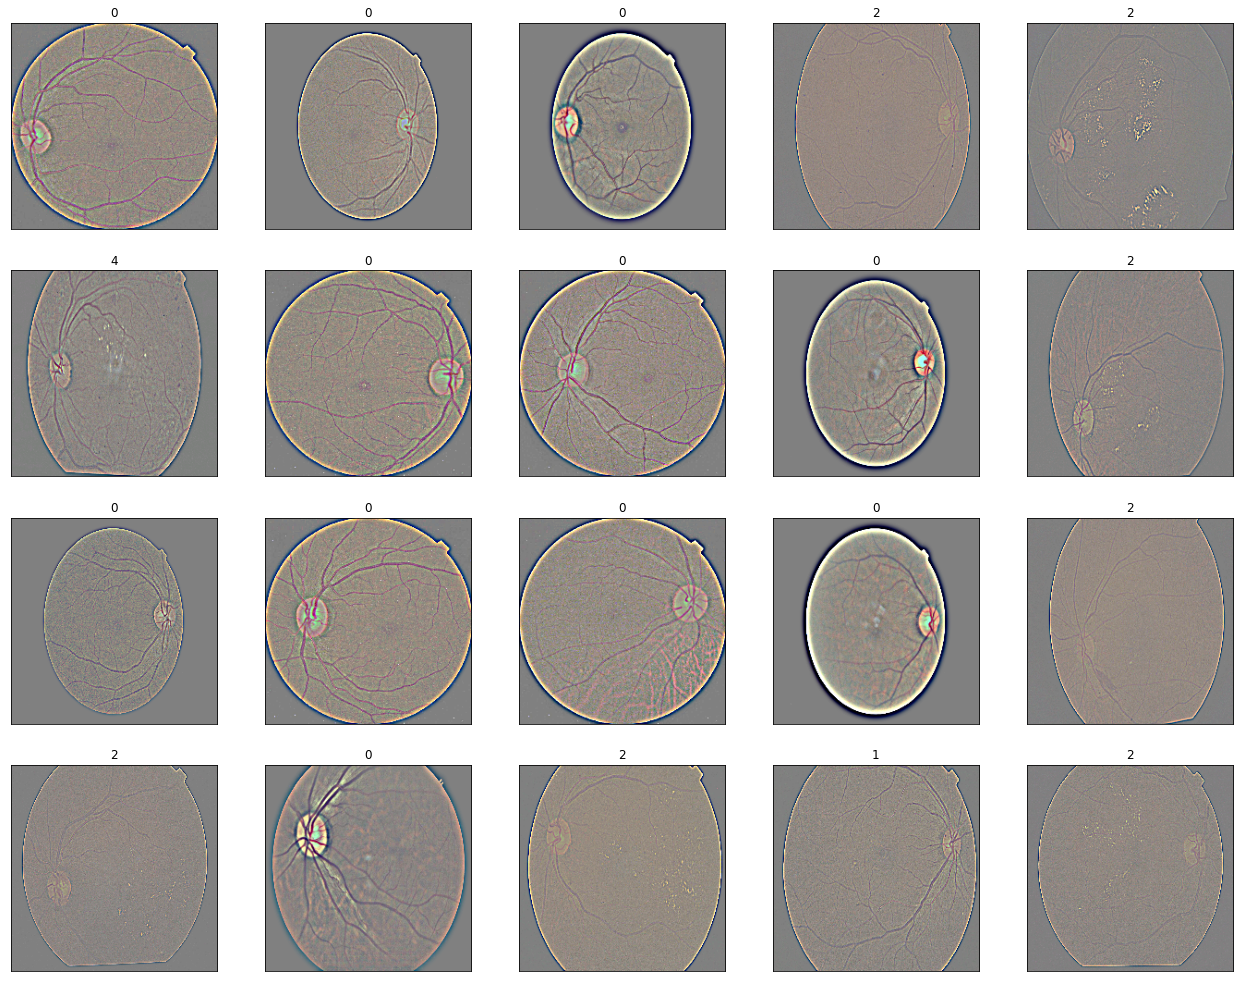

In [13]:
# Visualizing some data

# obtain one batch of testing images
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()
images = images.numpy() # converting images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(22, 22))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Define the Model

To define a model for training:
1. Load in a pre-trained model
2. "Freeze" all the parameters, so the network acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier layer of our own

**Freezing means that the parameters of features part in the pre-trained model will *not* change during training.**

In [9]:
model_name = 'multiclass classification'

In [10]:
model = models.resnet50(pretrained=True)

In [11]:
# print out the model structure
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Final layer input and output nodes

In [12]:
print(model.fc.in_features) 
print(model.fc.out_features) 

2048
1000


In [13]:
# Freeze training for all layers
for param in model.parameters():
    param.requires_grad = False
    

---
### Final Classifier Layer

After having the pre-trained feature extractor, modifying final-fully-connected classifier layer

> This layer should produce an appropriate number of outputs for this painting classification task.

(You can access any layer in a pretrained network by name and (sometimes) number, i.e. `resnet50.fc` is the only fully connected Linear layer.)

#### Note that-> editing / adding a new layer automatically makes `requires_grad` = True for it

In [14]:
import torch.nn as nn

n_inputs = model.fc.in_features

# add last linear layer (n_inputs --to---> 14 painting classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes)) 

model.fc = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    model=model.to(device)

# check to see that your last layer produces the expected number of outputs
print(model.fc.out_features)


5


In [15]:
#print the new model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Below we'll use cross-entropy loss and stochastic gradient descent\. Note that the optimizer accepts as input _only_ the trainable parameters `resnet.fc.parameters()`.


##### RESNET is made up multiple parts.  Last one is fc (Fully-connected layer).
In transfer-learning, only fully-connected layers are trained.

In [16]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specifying optimizer and learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

---
# Training




In [17]:
model_filename = model_name + '.pt'
print('File name for saved model: ',model_filename)

File name for saved model:  multiclass classification.pt


In [18]:
# number of epochs to train the model
n_epochs = 30

In [19]:
import time  #to calculate training time
a = time.time()  #Start-time for training

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity


train_losses,valid_losses, accuracies=[],[],[]

for epoch in range(1, n_epochs+1):
    c = time.time()  #Start-time for epoch
    
    # to keep track of training loss
    training_loss = 0.0
    
    
    ###################
    # train the model #
    ###################
    
    # model by default is set to train
    for batch_i, (images, labels) in enumerate(train_dataloader):    #Getting one batch of training images and their corresponding true labels
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images = images.to(device)
            labels = labels.to(device)
            
        # clear the previous/buffer gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model.forward(images)
        
        # calculate the batch loss
        loss = criterion(outputs, labels)    #(y_hat, y)  or (our-prediction, true-label)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss 
        training_loss += loss.item()   
        
        ###End of training
        
    
    ########################
    # validating the model #
    ########################      
    
    #validation loss and accuracy
    validation_loss = 0.0
    accuracy = 0.0

    model.eval() #model is put to evalution mode i.e. dropout is switched off

    with torch.no_grad():  #Turning off calculation of gradients (not required for validaiton)  {saves time}
        for images, labels in valid_dataloader:   #Getting one batch of validation images
            
            if train_on_gpu:   #moving data to GPU if available
                images = images.to(device)
                labels = labels.to(device)

            outputs = model.forward(images)
            batch_loss = criterion(outputs, labels)
            validation_loss += batch_loss.item()
            
            # Calculating accuracy
            ps = torch.exp(outputs)   #Turning raw output values into probabilities using exponential function

            #getting top one probablilty and its corresponding class for batch of images
            top_p, top_class = ps.topk(1, dim=1) 

            #Comparing our predictions to true labels
            equals = top_class == labels.view(*top_class.shape)   #equals is a list of values
            #incrementing values of 'accuracy' with equals
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()   #taking average of equals will give number of true-predictions
                                                #equals if of ByteTensor (boolean), changing it to FloatTensor for taking mean...
    
    
    train_losses.append(training_loss/len(train_dataloader))    
    valid_losses.append(validation_loss/len(valid_dataloader))
    accuracies.append(((accuracy/len(valid_dataloader))*100.0))
    d = time.time() #end-time for epoch
    
    print(f"Epoch {epoch} "
          f"Time: {int((d-c)/60)} min {int(d-c)%60} sec "
          f"Train loss: {training_loss/len(train_dataloader):.3f}.. "
          f"Validation loss: {validation_loss/len(valid_dataloader):.3f}.. "
          f"Validation accuracy: {((accuracy/len(valid_dataloader))*100.0):.3f}% "
          )
    
    training_loss = 0.0
    
    # save model if validation loss has decreased
    if ( validation_loss/len(valid_dataloader) <= valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min , validation_loss/len(valid_dataloader)))
        torch.save(model.state_dict(), model_filename) #Saving model 
        valid_loss_min = validation_loss/len(valid_dataloader)   #Minimum validation loss updated
    
    
    #After validation, model is put to training mode i.e. dropout is again switched on
    model.train()
          
    ###end of epoch 
            
b = time.time()  #end-time for training
print('\n\n\tTotal training time: ' , int((b-a)/(60*60)), "hour(s) " , int(((b-a)%(60*60))/60),"minute(s) ", int(((b-a)%(60*60))%60) , "second(s)")

Epoch 1 Time: 0 min 48 sec Train loss: 1.000.. Validation loss: 1.006.. Validation accuracy: 69.271% 
Validation loss decreased (inf --> 1.006414).  Saving model ...
Epoch 2 Time: 0 min 33 sec Train loss: 0.765.. Validation loss: 0.785.. Validation accuracy: 73.755% 
Validation loss decreased (1.006414 --> 0.785189).  Saving model ...
Epoch 3 Time: 0 min 33 sec Train loss: 0.707.. Validation loss: 0.723.. Validation accuracy: 73.682% 
Validation loss decreased (0.785189 --> 0.723103).  Saving model ...
Epoch 4 Time: 0 min 33 sec Train loss: 0.666.. Validation loss: 0.744.. Validation accuracy: 72.135% 
Epoch 5 Time: 0 min 33 sec Train loss: 0.650.. Validation loss: 0.697.. Validation accuracy: 74.236% 
Validation loss decreased (0.723103 --> 0.696759).  Saving model ...
Epoch 6 Time: 0 min 33 sec Train loss: 0.639.. Validation loss: 0.712.. Validation accuracy: 73.715% 
Epoch 7 Time: 0 min 33 sec Train loss: 0.619.. Validation loss: 0.706.. Validation accuracy: 73.890% 
Epoch 8 Time: 0

### Load the Model with the Lowest Validation Loss

In [20]:
model.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

---
## Testing

Below you see the test accuracy for each flower class.

In [21]:
import sklearn.metrics

# track test loss 
# over 14 painting classes
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
classes_accuracies=[]
model.eval() # evaluation mode (switching off dropout)
counter = 0

y_true=[]
y_pred=[]


# iterate over test data
for images, labels in test_dataloader: #geeting one batch of data from testloader
    
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images = images.to(device)
        labels = labels.to(device)
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(images)
    
    # calculate the batch loss
    loss = criterion(output, labels)
    
    # update  test loss 
    test_loss += loss.item()*images.size(0)
    
    # convert output probabilities to predicted class
    ps, pred = torch.max(output, 1)    
    
    
    
    # compare model's predictions to true labels
    for i in range(len(images)):
        class_total[labels[i]] += 1
        if pred[i] == labels[i]:
            class_correct[pred[i]] += 1
        '''
        if train_on_gpu:
            pred=pred.to('cpu')
            labels=labels.to('cpu')
        '''
        y_pred.append(pred[i].item())
        y_true.append(labels[i].item())
        
    counter += 1
    

#calculate avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    classes_accuracies.append(100 * class_correct[i] / class_total[i])
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % 
                          (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))


a = sklearn.metrics.confusion_matrix(y_true, y_pred)

Test Loss: 0.626936

Test Accuracy of     0: 98% (354/361)
Test Accuracy of     1: 51% (38/74)
Test Accuracy of     2: 68% (137/199)
Test Accuracy of     3: 26% (10/38)
Test Accuracy of     4: 27% (16/59)

Test Accuracy (Overall): 75% (555/731)


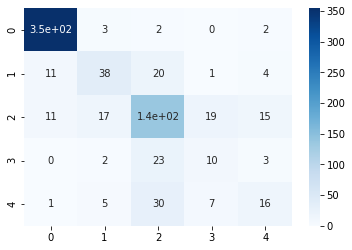

In [22]:
import seaborn as sns
sns.heatmap(a, annot=True , cmap='Blues' )

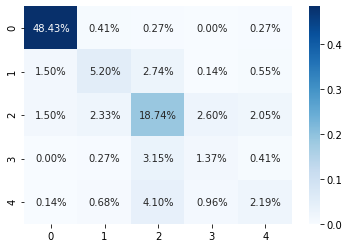

In [23]:
sns.heatmap(a/np.sum(a), annot=True, 
            fmt='.2%', cmap='Blues')

## Saving the best model along with `Training Loss`, `Validations Loss`, `Accuracy`, `Class Accuracy`

In [24]:
checkpoint = {'training_losses': train_losses,
              'valid_losses': valid_losses,
              'accuracies': accuracies,
              'classes_accuracies':classes_accuracies,
              'state_dict': model.state_dict(),
              'confusion_matrix' : a}
torch.save(checkpoint, model_filename)

### Visualize Sample Test Results

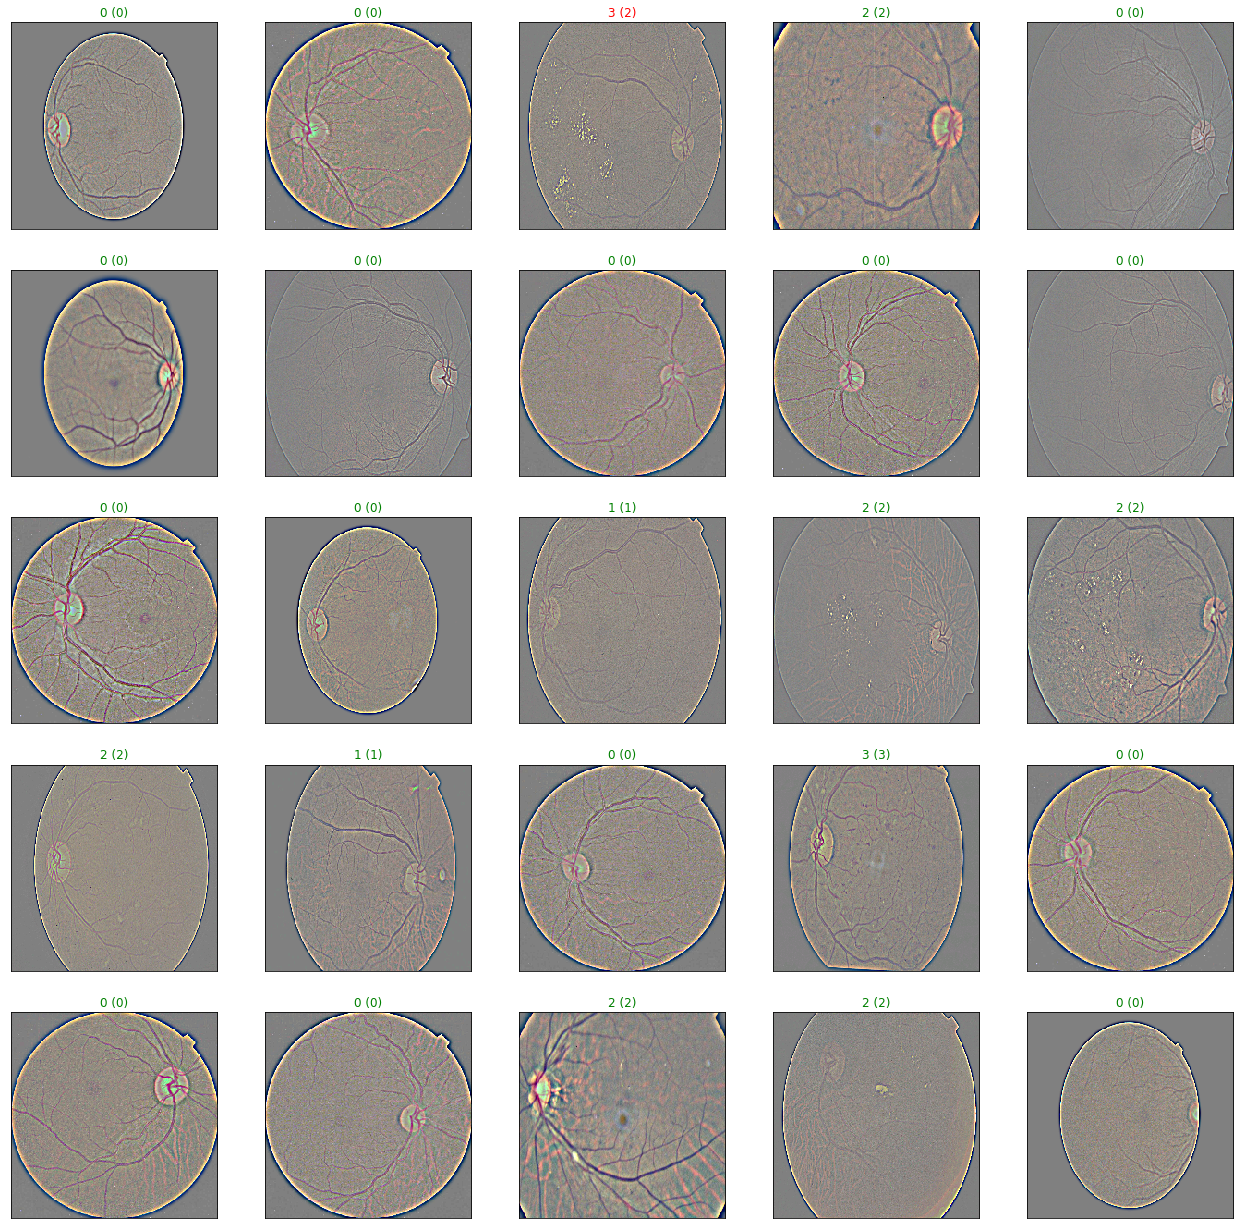

In [25]:
# obtain one batch of test images
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:    
    images = images.to(device)
    
# get sample outputs
output = model(images)

#move images to CPU for plotting
images = images.cpu()

# convert output probabilities to predicted class
output_ps, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(22, 22))
for idx in np.arange(25):
    ax = fig.add_subplot(5, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

#Format -> prediction(label)